In [2]:
%load_ext autoreload

%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from utils import _DeepLiftShap, _GradCAMPlusPlus, SimpleUpsampling, ERFUpsampling, cut_model_from_layer, cut_model_to_layer
from data import PascalVOC2007
from results.results_metrics import ResultMetrics
from models import vgg11_PascalVOC

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

Here the VGG-11 model is instantiated, the last layer is replaced with a new layer that has 20 outputs instead of 1000 (because PascalVOC has 20 classes, but the model was trained on ImageNet which has 1000 classes). The loaded weights are pretrained on ImageNet and the fine-tuned on PascalVOC. For more detail about the fine-tuning process, see `fine_tuning.py`.

In [3]:
model = vgg11_PascalVOC()
model.to(device)
# Load the pretrained weights
model.load_state_dict(torch.load('VGG11_PascalVOC.pt', map_location=device))
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                 # Convert to Tensor
    transforms.Normalize(                  # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


In [4]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [5]:
import torchsummary

torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

In [6]:
test_data = PascalVOC2007("test", transform=preprocess)
train_data = PascalVOC2007("trainval", transform=preprocess)

Using downloaded and verified file: data\VOCtest_06-Nov-2007.tar
Extracting data\VOCtest_06-Nov-2007.tar to data
Using downloaded and verified file: data\VOCtrainval_06-Nov-2007.tar
Extracting data\VOCtrainval_06-Nov-2007.tar to data


The train data is only used in the case of DeepLiftSHAP, because it requires a baseline distribution.

In [7]:
import torch.utils
from torch.utils.data import Subset

BATCH_SIZE_TEST = 2
NUM_TEST = 2

BATCH_SIZE_TRAIN = 2
NUM_TRAIN = 8

dl_test = DataLoader(Subset(test_data, torch.randperm(len(test_data))[:NUM_TEST]), batch_size=BATCH_SIZE_TEST, shuffle=False)
dl_train = DataLoader(Subset(train_data, torch.randperm(len(train_data))[:NUM_TRAIN]), batch_size=BATCH_SIZE_TRAIN, shuffle=True)

The sum of all the attributions is equal to the difference between the output of the model on the current input, minus the average output of the model on the baseline distribution.

- The parameter `attribution_method` is an object that extends the base class `AttributionMethod` and implements the method `attribute`. In this way, simply changing the object passed to the `explain` method, we can change the attribution method used.
- The parameter `train_dl` is only used by the DeepLiftSHAP method, because it requires a baseline distribution.
- The function automatically add the metrics to the `ResultMetrics` object passed as parameter.
- The boolean `rescale_saliency` is used to rescale the saliency map in such a way that the integral of the saliency map is equal to $r \times (H \times W)$, where $H$ and $W$ are the height and width of the saliency map, and $r \in [0, 1]$ is the rescale factor.
    - This is useful to compare different saliency maps methods, because, for example, producing a saliency map with all ones is not useful, but gives the best results for some of the metrics.
    - The scaling is done in such a way that the positions and the values where the saliency map is equal to one are not changed. More formally, given the saliency map $S(i, j): \mathbb{R}^2 \rightarrow [0,1]$, the rescaled saliency map $S'(i, j) = S(i,j)^{\alpha^2}$ is found as an optimization problem by defining:

    $$L(S(i,j), \alpha) = \left( \sum_{i,j} S(i,j)^{\alpha^2}  - (r \times H \times W) \right)^2$$

    $$\alpha = \arg \min_{\alpha \in \mathbb{R}} L(S(i,j), \alpha)$$

    - It can be seen as a way to constraint the saliency map into keeping only a limited amount of important pixels.

In [8]:
bilinear_upsampling = SimpleUpsampling(size=(224, 224), mode='bilinear')

## DeepLiftShap

In [10]:
from metrics import calculate_metrics, Infidelity, RoadCombined, Sensitivity

RESULT_PATH = "./results.csv"

results = ResultMetrics(RESULT_PATH)
calculate_metrics(model,
                _DeepLiftShap(),
                dl_test,
                dl_train,
                layers=[f for f in model.features],
                metrics=[Sensitivity()],
                result_metrics=results,
                device=device,
                upsample=bilinear_upsampling,
                rescale_saliency=False,
                model_name="VGG11",
                debug=False
                )

Results loaded from ./results.csv.


  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


KeyboardInterrupt: 

## DeepLiftShap with rescaling ($r=0.3$)

In [ ]:
from metrics import calculate_metrics

RESULT_PATH = "./results.csv"

results = ResultMetrics(RESULT_PATH)
calculate_metrics(model,
                _DeepLiftShap(),
                dl_test,
                dl_train,
                layers=[f for f in model.features],
                result_metrics=results,
                device=device,
                upsample=bilinear_upsampling,
                rescale_saliency=True,
                model_name="VGG11_Rescaling",
                debug=False
                )

## GradCam++

In [ ]:
from metrics import calculate_metrics

RESULT_PATH = "./results.csv"

results = ResultMetrics(RESULT_PATH)

for f in model.features:
    attr = _GradCAMPlusPlus(model, f)
    calculate_metrics(model,
                    attr,
                    dl_test,
                    dl_train,
                    layers=[f],
                    result_metrics=results,
                    device=device,
                    upsample=bilinear_upsampling,
                    rescale_saliency=False,
                    model_name="VGG11")

## GradCam++ with rescaling ($r=0.3$)

In [ ]:
from metrics import calculate_metrics

RESULT_PATH = "./results.csv"

results = ResultMetrics(RESULT_PATH)

for f in model.features:
    attr = _GradCAMPlusPlus(model, f)
    calculate_metrics(model,
                    attr,
                    dl_test,
                    dl_train,
                    layers=[f],
                    result_metrics=results,
                    device=device,
                    upsample=bilinear_upsampling,
                    rescale_saliency=True,
                    model_name="VGG11_Rescaling")

In [10]:
BATCH_SIZE_TEST = 1
NUM_TEST = 8

dl_test_small = DataLoader(Subset(test_data, torch.randperm(len(test_data))[:NUM_TEST]), batch_size=BATCH_SIZE_TEST, shuffle=False)

In [24]:
from metrics import calculate_metrics

RESULT_PATH = "./results.csv"

results = ResultMetrics(RESULT_PATH)
for layer in model.features[-1:]:
    feature_extractor = cut_model_to_layer(model, layer, included=True)  # Model from the start up to the layer
    erf_upsampling = ERFUpsampling(feature_extractor, device)
    calculate_metrics(model,
                    _DeepLiftShap(),
                    dl_test_small,
                    dl_train,
                    layers=[layer],
                    result_metrics=results,
                    device=device,
                    upsample=erf_upsampling,
                    rescale_saliency=False,
                    model_name="VGG11",
                    debug=False
                    )

Results loaded from ./results.csv.


  0%|          | 0/8 [00:00<?, ?it/s]

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


  0%|          | 0/7 [00:00<?, ?it/s]

erf.shape:(7, 7, 3, 224, 224)
attribution.shape:(7, 7)
result.shape:(3, 224, 224)
image.shape:torch.Size([1, 3, 224, 224])


  0%|          | 0/7 [00:00<?, ?it/s]

erf.shape:(7, 7, 3, 224, 224)
attribution.shape:(7, 7)
result.shape:(3, 224, 224)
image.shape:torch.Size([1, 3, 224, 224])


  0%|          | 0/7 [00:00<?, ?it/s]

erf.shape:(7, 7, 3, 224, 224)
attribution.shape:(7, 7)
result.shape:(3, 224, 224)
image.shape:torch.Size([1, 3, 224, 224])


  0%|          | 0/7 [00:00<?, ?it/s]

erf.shape:(7, 7, 3, 224, 224)
attribution.shape:(7, 7)
result.shape:(3, 224, 224)
image.shape:torch.Size([1, 3, 224, 224])


  0%|          | 0/7 [00:00<?, ?it/s]

erf.shape:(7, 7, 3, 224, 224)
attribution.shape:(7, 7)
result.shape:(3, 224, 224)
image.shape:torch.Size([1, 3, 224, 224])


  0%|          | 0/7 [00:00<?, ?it/s]

erf.shape:(7, 7, 3, 224, 224)
attribution.shape:(7, 7)
result.shape:(3, 224, 224)
image.shape:torch.Size([1, 3, 224, 224])


  0%|          | 0/7 [00:00<?, ?it/s]

erf.shape:(7, 7, 3, 224, 224)
attribution.shape:(7, 7)
result.shape:(3, 224, 224)
image.shape:torch.Size([1, 3, 224, 224])


  0%|          | 0/7 [00:00<?, ?it/s]

erf.shape:(7, 7, 3, 224, 224)
attribution.shape:(7, 7)
result.shape:(3, 224, 224)
image.shape:torch.Size([1, 3, 224, 224])


c:\Users\Luca\Desktop\MagistraleAI\2nd_year\Artificial Intelligence in Industry\project\results\results_metrics.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0


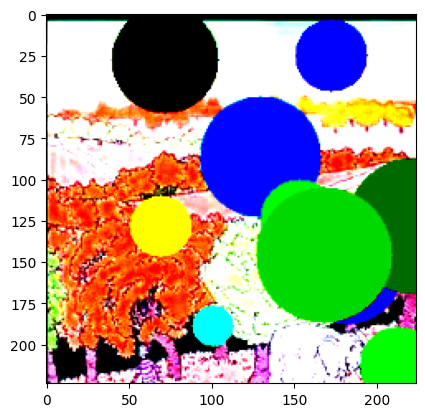

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


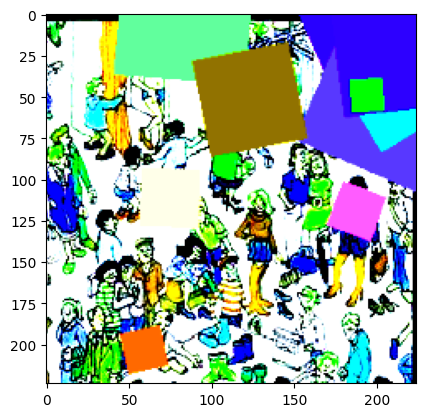

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


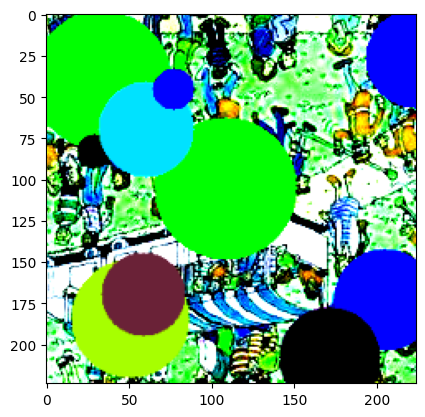

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


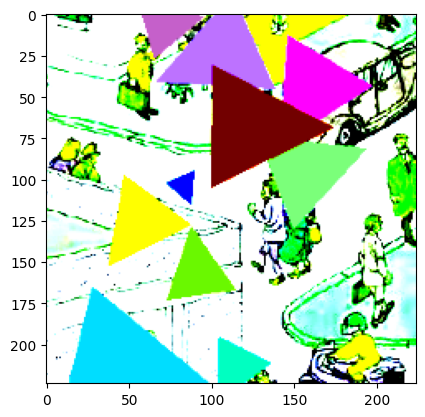

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


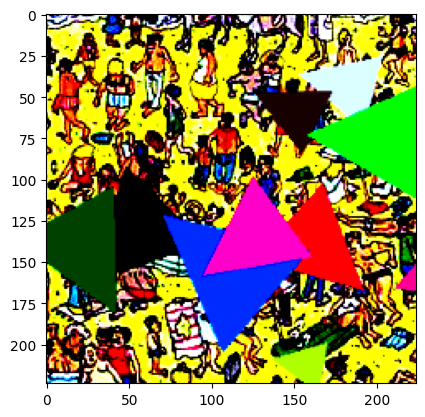

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2


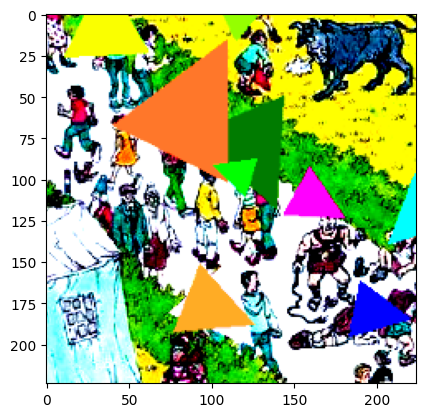

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


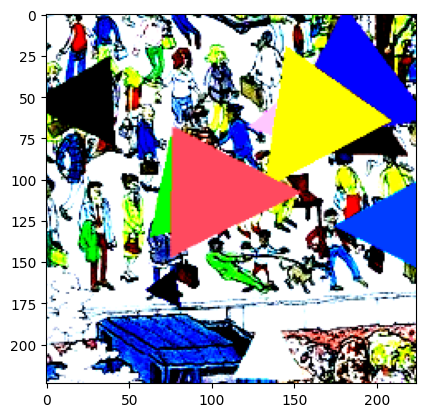

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


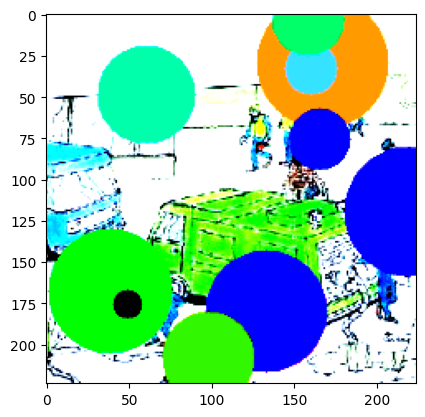

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


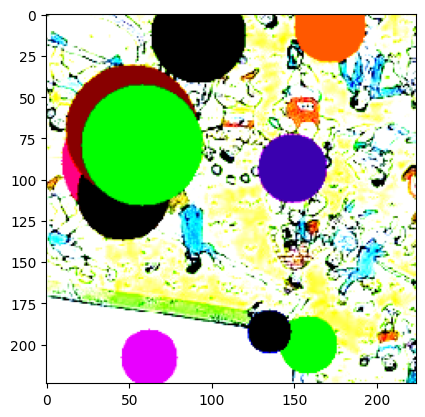

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


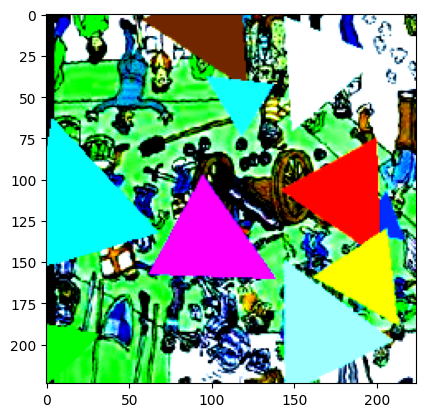

In [ ]:
%load_ext autoreload

%autoreload 2

from data import SynteticFigures
import matplotlib.pyplot as plt
from torchvision import transforms

background_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
])

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                 # Convert to Tensor
    transforms.Normalize(                  # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

syntethic_data = SynteticFigures("./data/Waldo", background_transform=background_transform, image_transform=image_transform)


for i in range(10):
    img = syntethic_data[i][0]
    label = syntethic_data[i][1]
    print(label)
    plt.imshow(syntethic_data[i][0].permute(1, 2, 0))
    plt.show()